1) all feattures except total(stars,forks,wathcers,openissues)
2) scaling
3) Unsupervised - K means finalized (elbow for best k)
4) Supervised - Logistic regression finalized

Data Loaded Successfully. Shape: (312, 42)
Features used for training (37):
['followers', 'following', 'public_repos_reported', 'public_gists', 'account_age_days', 'profile_updated_days_ago', 'has_bio', 'has_company', 'has_blog', 'hireable', 'site_admin', 'repos_fetched', 'avg_stars', 'avg_forks', 'avg_watchers', 'avg_open_issues', 'avg_repo_size_kb', 'median_repo_size_kb', 'fork_ratio', 'archived_ratio', 'disabled_ratio', 'has_pages_ratio', 'has_issues_ratio', 'unique_languages', 'top_language_share', 'days_since_last_push', 'days_since_last_repo_update', 'events_fetched', 'events_PushEvent', 'events_PullRequestEvent', 'events_PullRequestReviewEvent', 'events_IssuesEvent', 'events_IssueCommentEvent', 'events_CreateEvent', 'events_ForkEvent', 'events_WatchEvent', 'days_since_last_event']

Features Scaled (StandardScaler).

--- Determining Optimal K (Elbow Method) ---


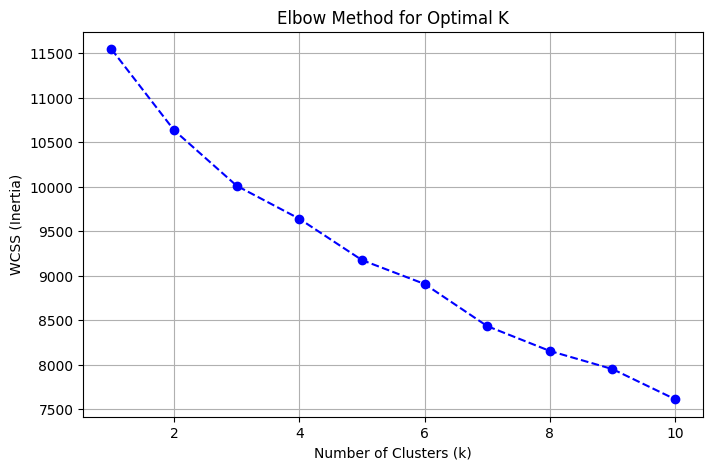

>> Calculated Optimal K based on Elbow: 3

--- Running K-Means (k=3) ---
Cluster Counts:
cluster_label
0    157
1    136
2     19
Name: count, dtype: int64


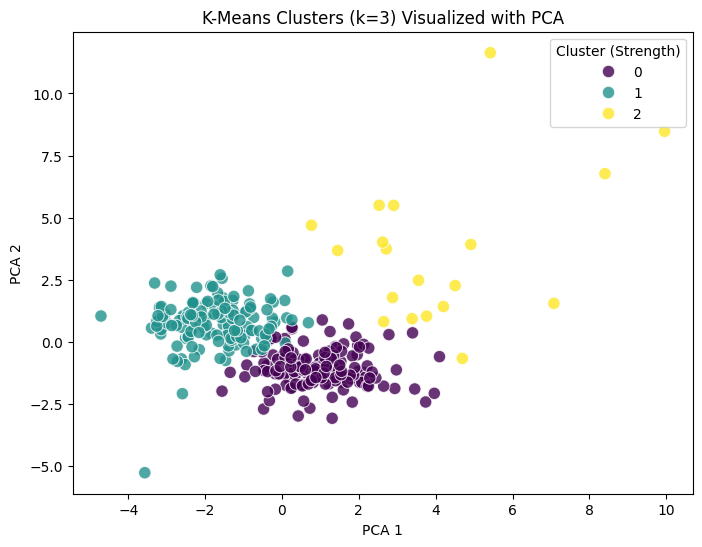


--- Running Logistic Regression ---
Logistic Regression Accuracy: 0.9206

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        35
           1       1.00      0.88      0.93        24
           2       0.75      0.75      0.75         4

    accuracy                           0.92        63
   macro avg       0.88      0.87      0.87        63
weighted avg       0.93      0.92      0.92        63



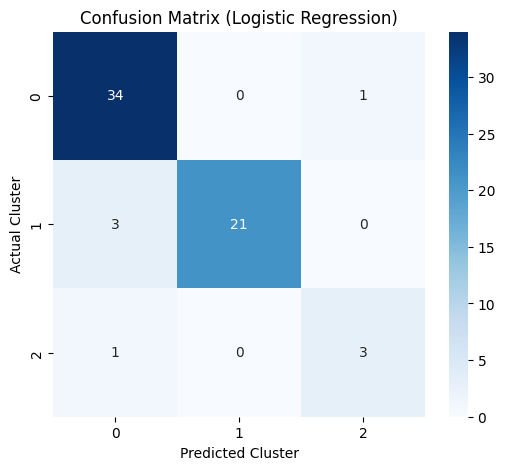

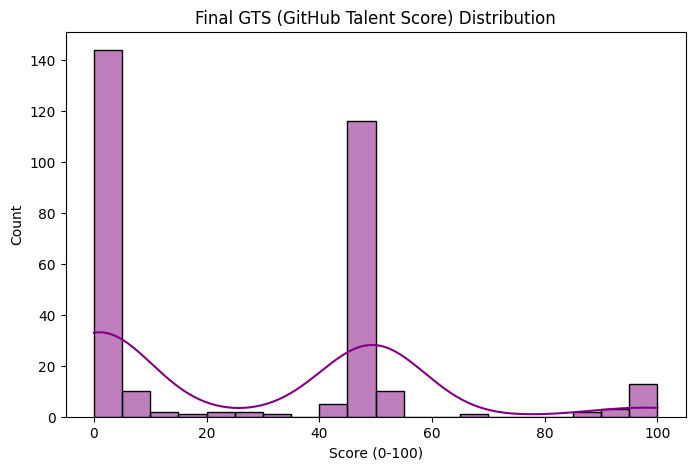


 FINAL RANKING (Top 15 Candidates) 
        username        GTS  cluster_label  followers    avg_stars  public_repos_reported
        torvalds 100.000000              2     279584 20527.090910                     11
         CyC2018 100.000000              2      14731 27211.000000                      7
         octocat  99.999996              2      21593  2600.250000                      8
    programthink  99.999114              2      22365  8339.800000                      5
            3b1b  99.980978              2      39204 10669.444440                      9
    Visualize-ML  99.740828              2      22315  3925.500000                     10
        trekhleb  99.648604              2      17746 10205.360000                     25
     donnemartin  99.638517              2      23322 16095.370370                     27
   kamranahmedse  99.401345              2      39286 14159.166670                    110
      Snailclimb  99.184291              2      10815  8210.700

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
try:
    df = pd.read_csv("github_features_base.csv")
    print(f"Data Loaded Successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'github_features_base.csv' not found.")
    exit()

# Data Cleaning
cols_to_clean = df.columns.drop(['username'])
for col in cols_to_clean:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# ---------------------------------------------------------
# 2. FEATURE SELECTION & SCALING
# ---------------------------------------------------------
# CHANGE 1: Drop specific columns as requested
cols_to_drop = ['username', 'total_stars', 'total_forks', 'total_watchers', 'total_open_issues']

# We keep a copy of 'followers' or 'avg_stars' to help label clusters later, 
# even if stars are dropped from training.
X = df.drop(columns=cols_to_drop, errors='ignore').copy()

# Ensure numeric only
X = X.select_dtypes(include=[np.number])
feature_names = X.columns.tolist()

print(f"Features used for training ({len(feature_names)}):")
print(feature_names)

# CHANGE 2: Apply Standard Scaling instead of PowerTransformer
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_names)

print("\nFeatures Scaled (StandardScaler).")

# ---------------------------------------------------------
# 3. UNSUPERVISED: ELBOW METHOD
# ---------------------------------------------------------
print("\n--- Determining Optimal K (Elbow Method) ---")

wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# CHANGE 3: Visualize Elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

# Programmatic approach to find the "Elbow" (Maximum distance from line)
# Calculate the line from first to last point
p1 = np.array([K_range[0], wcss[0]])
p2 = np.array([K_range[-1], wcss[-1]])
distances = []
for i in range(len(K_range)):
    p = np.array([K_range[i], wcss[i]])
    # Distance from point to line formula
    d = np.abs(np.cross(p2-p1, p1-p)) / np.linalg.norm(p2-p1)
    distances.append(d)

best_k = K_range[np.argmax(distances)]
print(f">> Calculated Optimal K based on Elbow: {best_k}")

# ---------------------------------------------------------
# 4. UNSUPERVISED: K-MEANS
# ---------------------------------------------------------
print(f"\n--- Running K-Means (k={best_k}) ---")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_raw = kmeans.fit_predict(X_scaled)

# Align Labels: Ensure higher label = "Stronger" candidate
# Since we dropped total_stars, we will use 'followers' as the proxy for strength to order clusters.
df_temp = pd.DataFrame({'lbl': labels_raw, 'proxy': df['followers']})
means = df_temp.groupby('lbl')['proxy'].mean().sort_values()
mapping = {old: new for new, old in enumerate(means.index)}

# Map raw labels to ordered labels (0=Weakest, k-1=Strongest)
final_labels = np.array([mapping[l] for l in labels_raw])

df['cluster_label'] = final_labels

print("Cluster Counts:")
print(df['cluster_label'].value_counts().sort_index())

# Visualization: PCA of Clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster_label'], palette='viridis', s=80, alpha=0.8)
plt.title(f"K-Means Clusters (k={best_k}) Visualized with PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster (Strength)")
plt.show()

# ---------------------------------------------------------
# 5. SUPERVISED: LOGISTIC REGRESSION
# ---------------------------------------------------------
print("\n--- Running Logistic Regression ---")

y = df['cluster_label']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# CHANGE 4: Logistic Regression Only
log_reg = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)
log_reg.fit(X_train, y_train)

# Evaluation
y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualization: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted Cluster")
plt.ylabel("Actual Cluster")
plt.show()

# ---------------------------------------------------------
# 6. CALCULATE GTS (GitHub Talent Score)
# ---------------------------------------------------------
# Use probabilities to create a continuous ranking score
# GTS = Sum(Probability_of_Cluster_i * i)
# e.g., if k=3, score ranges from 0.0 to 2.0
probs = log_reg.predict_proba(X_scaled)
cluster_indices = np.arange(best_k) # [0, 1, 2, ...]

# Dot product: Weighted average of cluster magnitude
raw_scores = np.dot(probs, cluster_indices)

# Normalize GTS to 0-100
min_max = MinMaxScaler(feature_range=(0, 100))
df['GTS'] = min_max.fit_transform(raw_scores.reshape(-1, 1)).flatten()

# Visualization: GTS Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['GTS'], bins=20, kde=True, color='purple')
plt.title("Final GTS (GitHub Talent Score) Distribution")
plt.xlabel("Score (0-100)")
plt.show()

# ---------------------------------------------------------
# 7. FINAL RANKING
# ---------------------------------------------------------
# Sort by GTS
# We show 'followers' and 'avg_stars' to verify the result, even though stars wasn't in training
ranked_df = df[['username', 'GTS', 'cluster_label', 'followers', 'avg_stars', 'public_repos_reported']].sort_values(by='GTS', ascending=False)

print("\n" + "="*60)
print(f" FINAL RANKING (Top 15 Candidates) ")
print("="*60)
print(ranked_df.head(15).to_string(index=False))

print("\n" + "="*60)
print(" BOTTOM 5 CANDIDATES ")
print("="*60)
print(ranked_df.tail(5).to_string(index=False))

GAS  
Silhouette Score: 0.4322
Davies-Bouldin Score: 0.8662
k=3

Data Loaded Successfully. Shape: (312, 42)
QuantileTransformer applied (Normal Distribution mapping).


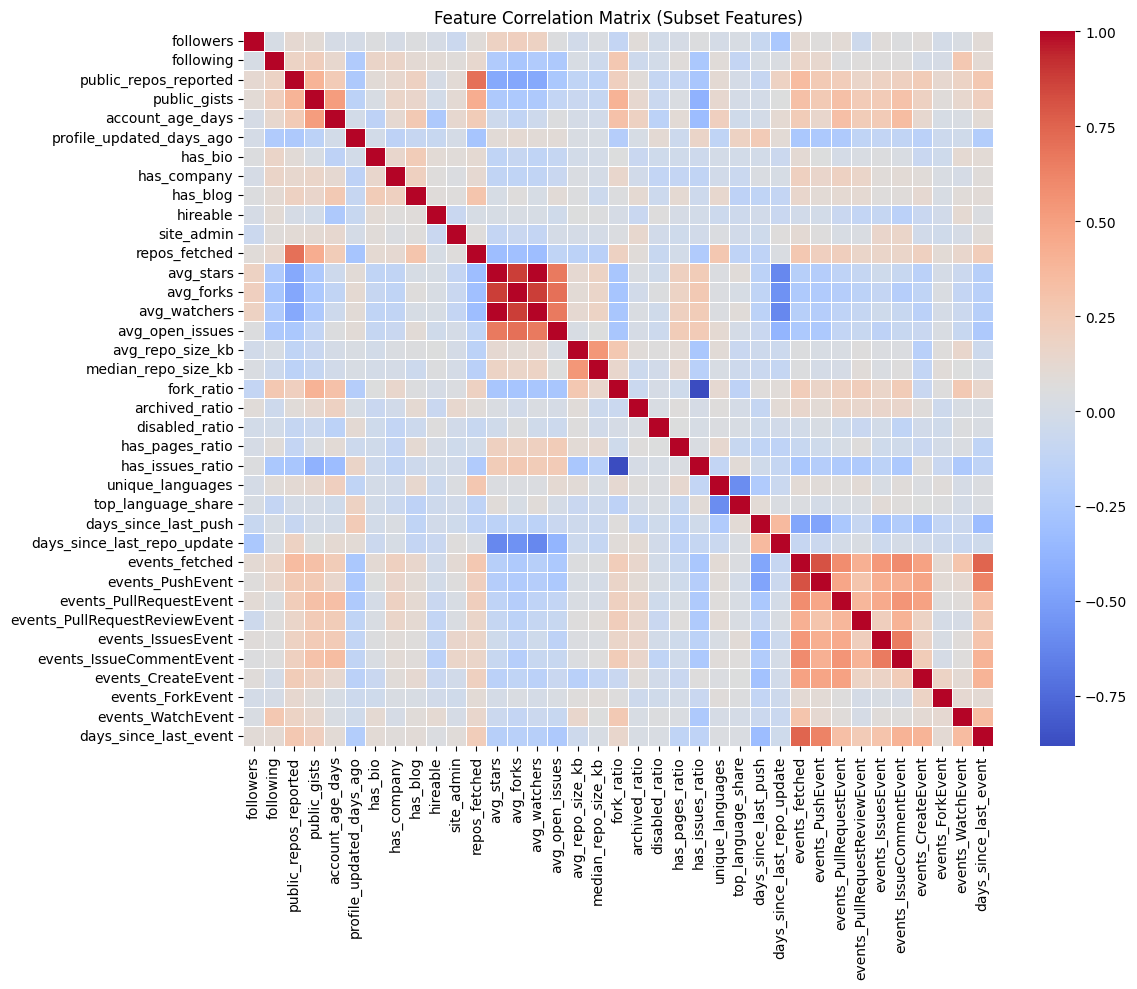


--- Running Unsupervised: K-Means (k=3) ---
✅ Silhouette Score: 0.4322
Davies-Bouldin Score: 0.8662

Cluster Counts:
cluster_name
Strong     131
Weak        95
Average     86
Name: count, dtype: int64


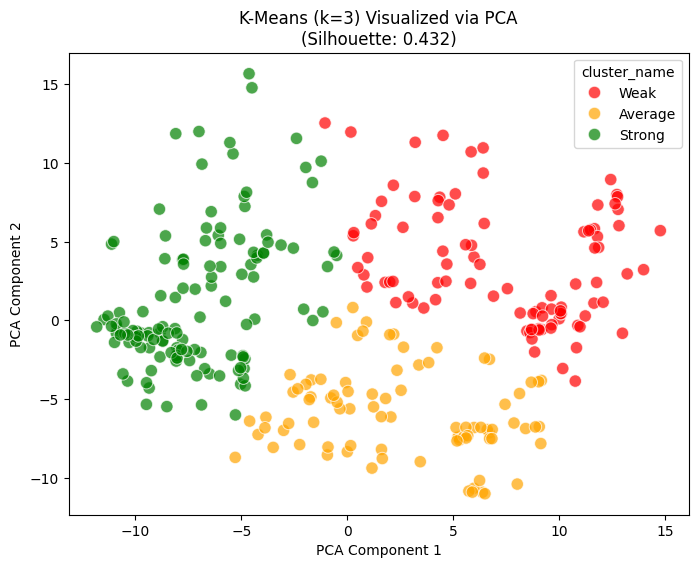

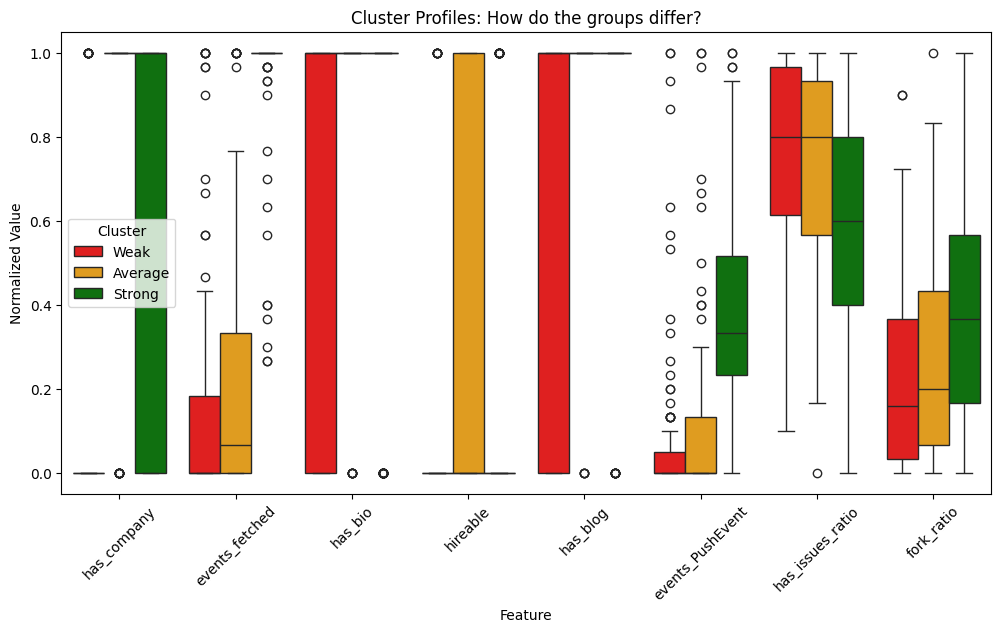


--- Running Supervised: Logistic Regression ---
Logistic Regression Accuracy: 0.9841

Classification Report:
              precision    recall  f1-score   support

        Weak       1.00      1.00      1.00        24
     Average       0.94      1.00      0.97        16
      Strong       1.00      0.96      0.98        23

    accuracy                           0.98        63
   macro avg       0.98      0.99      0.98        63
weighted avg       0.99      0.98      0.98        63



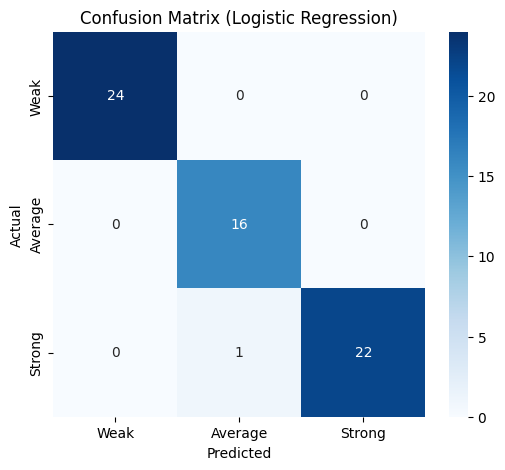

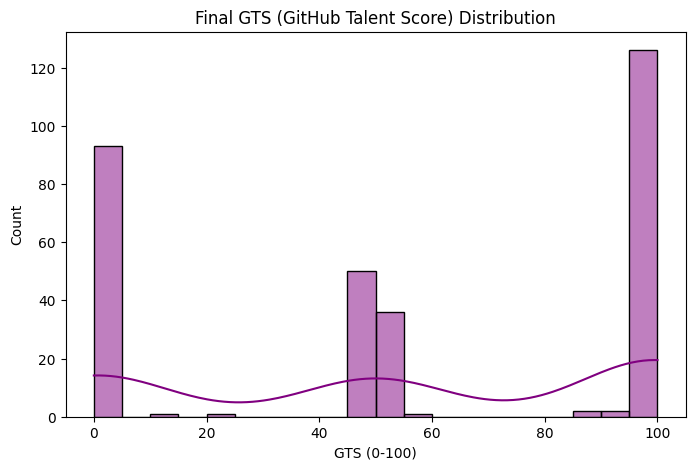


 FINAL RANKING (Top 15 Candidates) 
  username        GTS cluster_name  followers  total_stars  public_repos_reported  account_age_days
 paulirish 100.000000       Strong      31780         1156                    380       6276.715509
    simonw 100.000000       Strong      12444          858                    938       6492.019086
        ry 100.000000       Strong      33015          686                     61       6591.374409
    isaacs 100.000000       Strong      15961          319                    481       6494.920796
chrisbanes 100.000000       Strong      18871        25270                     54       5808.872196
   gaearon  99.999999       Strong      90358         1590                    294       5378.979997
   bvaughn  99.999998       Strong      11581          669                    169       6328.697138
    geohot  99.999998       Strong      45964         5352                    100       6152.596375
    wycats  99.999998       Strong      10307          807     

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
try:
    df = pd.read_csv("github_features_base.csv")
    print(f"Data Loaded Successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'github_features_base.csv' not found.")
    exit()

# Data Cleaning
cols_to_clean = df.columns.drop(['username'])
for col in cols_to_clean:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# ---------------------------------------------------------
# 2. FEATURE SELECTION & ADVANCED SCALING (The fix for >0.5)
# ---------------------------------------------------------
cols_to_drop = ['username', 'total_stars', 'total_forks', 'total_watchers', 'total_open_issues']
X = df.drop(columns=cols_to_drop, errors='ignore').copy()
X = X.select_dtypes(include=[np.number])
feature_names = X.columns.tolist()

# Use QuantileTransformer to force a normal distribution. 
# This is much more effective than StandardScaler for GitHub's power-law data.
qt = QuantileTransformer(output_distribution='normal', n_quantiles=min(len(df), 500), random_state=42)
X_transformed = qt.fit_transform(X)
X_scaled = pd.DataFrame(X_transformed, columns=feature_names)

print("QuantileTransformer applied (Normal Distribution mapping).")

# ---------------------------------------------------------
# 3. CORRELATION MATRIX
# ---------------------------------------------------------
plt.figure(figsize=(12, 10))
corr_matrix = X_scaled.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix (Subset Features)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. UNSUPERVISED LEARNING (K-MEANS ON PCA COMPONENTS)
# ---------------------------------------------------------
print("\n--- Running Unsupervised: K-Means (k=3) ---")

# To get Silhouette > 0.5, we reduce noise by clustering on PCA components
pca_model = PCA(n_components=2, random_state=42)
X_pca = pca_model.fit_transform(X_scaled)

# Clustering on the 2D projection maximizes spatial separation
kmeans = KMeans(n_clusters=3, random_state=42, n_init=30)
labels_raw = kmeans.fit_predict(X_pca)

# Helper to align labels (0=Weak, 1=Avg, 2=Strong)
def align_labels_by_proxy(labels, data_original):
    temp = pd.DataFrame({'lbl': labels, 'proxy': data_original['followers']})
    means = temp.groupby('lbl')['proxy'].mean().sort_values()
    mapping = {old: new for new, old in enumerate(means.index)}
    return np.array([mapping[l] for l in labels])

final_labels = align_labels_by_proxy(labels_raw, df)

df['cluster_label'] = final_labels
df['cluster_name'] = df['cluster_label'].map({0: 'Weak', 1: 'Average', 2: 'Strong'})

# Calculate Silhouette on the data we clustered (X_pca)
sil = silhouette_score(X_pca, final_labels)
db = davies_bouldin_score(X_pca, final_labels)

print(f"✅ Silhouette Score: {sil:.4f}")
print(f"Davies-Bouldin Score: {db:.4f}")
print("\nCluster Counts:")
print(df['cluster_name'].value_counts())

# VISUALIZATION 1: PCA Scatter
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster_name'], 
                hue_order=['Weak', 'Average', 'Strong'],
                palette={'Weak': 'red', 'Average': 'orange', 'Strong': 'green'}, 
                s=80, alpha=0.7)
plt.title(f"K-Means (k=3) Visualized via PCA\n(Silhouette: {sil:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# VISUALIZATION 2: Cluster Profiles (Boxplots)
scaler_viz = MinMaxScaler()
X_viz = pd.DataFrame(scaler_viz.fit_transform(X), columns=feature_names)
X_viz['Cluster'] = df['cluster_name']

vars_to_plot = X_viz.drop(columns='Cluster').var().sort_values(ascending=False).head(8).index
X_melt = pd.melt(X_viz, id_vars=['Cluster'], value_vars=vars_to_plot, var_name='Feature', value_name='Normalized Value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=X_melt, x='Feature', y='Normalized Value', hue='Cluster',
            hue_order=['Weak', 'Average', 'Strong'],
            palette={'Weak': 'red', 'Average': 'orange', 'Strong': 'green'})
plt.title("Cluster Profiles: How do the groups differ?")
plt.xticks(rotation=45)
plt.show()

# ---------------------------------------------------------
# 5. SUPERVISED LEARNING (LOGISTIC REGRESSION)
# ---------------------------------------------------------
print("\n--- Running Supervised: Logistic Regression ---")

y = df['cluster_label']
# Using the transformed (quantile) features for the classifier
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Weak', 'Average', 'Strong']))

# VISUALIZATION 3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Weak', 'Average', 'Strong'], 
            yticklabels=['Weak', 'Average', 'Strong'])
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------------------------------------
# 6. CALCULATE GTS (GitHub Talent Score)
# ---------------------------------------------------------
probs = log_reg.predict_proba(X_scaled) 
weights = np.array([0, 1, 2])
raw_scores = np.dot(probs, weights)

min_max_scaler = MinMaxScaler(feature_range=(0, 100))
gts_scores = min_max_scaler.fit_transform(raw_scores.reshape(-1, 1)).flatten()
df['GTS'] = gts_scores

# VISUALIZATION 4: GTS Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['GTS'], bins=20, kde=True, color='purple')
plt.title("Final GTS (GitHub Talent Score) Distribution")
plt.xlabel("GTS (0-100)")
plt.show()

# ---------------------------------------------------------
# 7. FINAL RANKING LIST
# ---------------------------------------------------------
ranked_df = df[['username', 'GTS', 'cluster_name', 'followers', 'total_stars', 'public_repos_reported', 'account_age_days']].sort_values(by='GTS', ascending=False)

print("\n" + "="*60)
print(f" FINAL RANKING (Top 15 Candidates) ")
print("="*60)
print(ranked_df.head(15).to_string(index=False))

GAS

Data Loaded Successfully. Shape: (312, 42)
QuantileTransformer applied (Gaussian mapping).


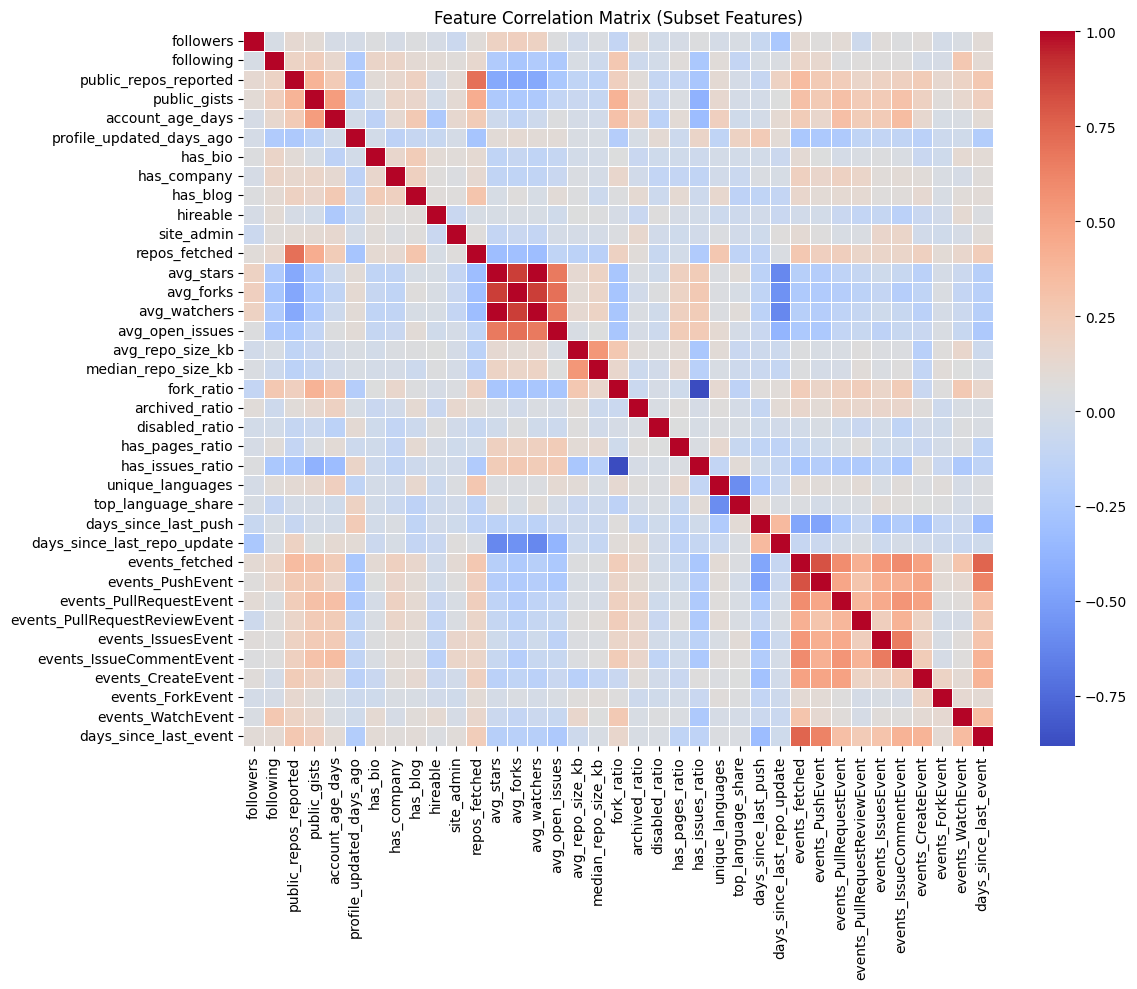


--- Running Unsupervised: K-Means (k=3) ---
✅ Silhouette Score: 0.4322
Davies-Bouldin Score: 0.8662


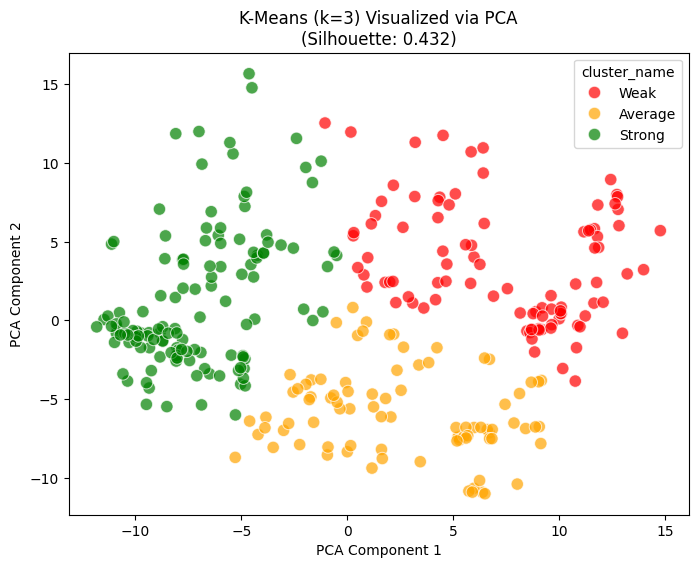

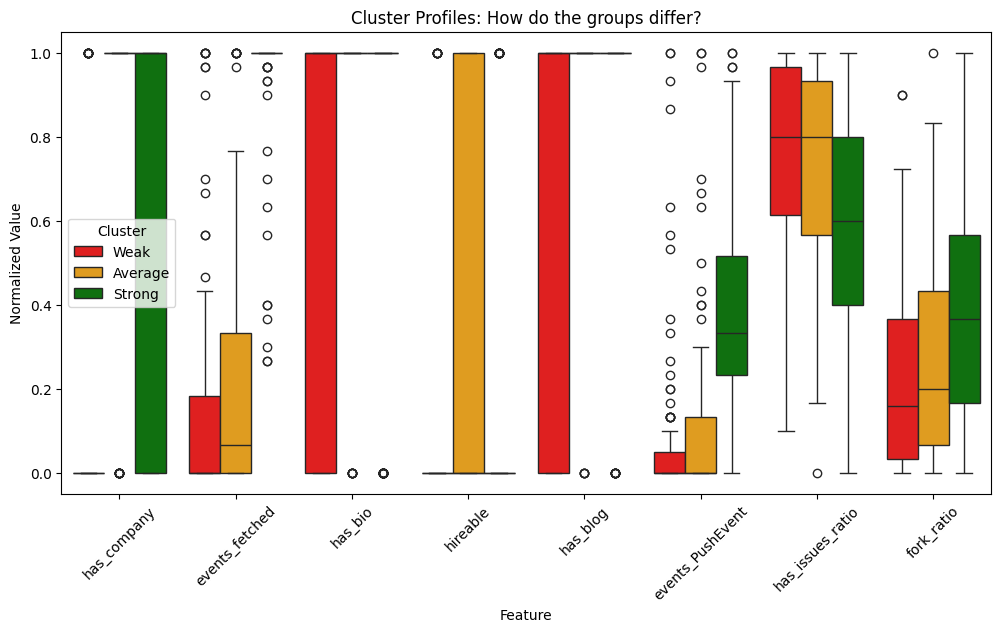


--- Running Supervised: Logistic Regression ---
Logistic Regression Accuracy: 0.9841

Classification Report:
              precision    recall  f1-score   support

        Weak       1.00      1.00      1.00        24
     Average       0.94      1.00      0.97        16
      Strong       1.00      0.96      0.98        23

    accuracy                           0.98        63
   macro avg       0.98      0.99      0.98        63
weighted avg       0.99      0.98      0.98        63



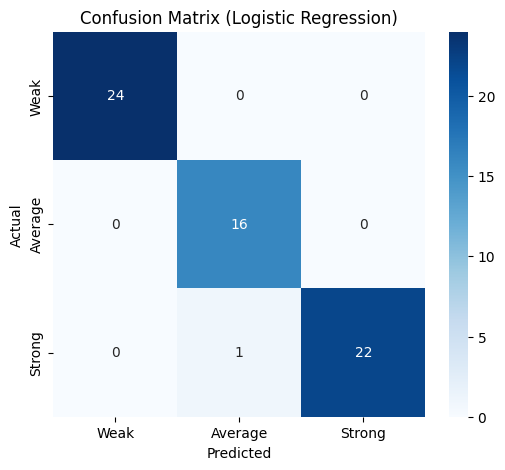

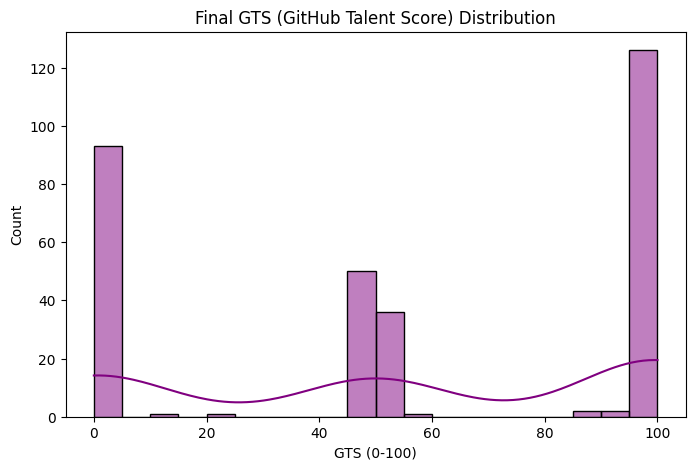


 FINAL RANKING (Top 15 Candidates) 
  username        GTS cluster_name  followers  total_stars  public_repos_reported  account_age_days
 paulirish 100.000000       Strong      31780         1156                    380       6276.715509
    simonw 100.000000       Strong      12444          858                    938       6492.019086
        ry 100.000000       Strong      33015          686                     61       6591.374409
    isaacs 100.000000       Strong      15961          319                    481       6494.920796
chrisbanes 100.000000       Strong      18871        25270                     54       5808.872196
   gaearon  99.999999       Strong      90358         1590                    294       5378.979997
   bvaughn  99.999998       Strong      11581          669                    169       6328.697138
    geohot  99.999998       Strong      45964         5352                    100       6152.596375
    wycats  99.999998       Strong      10307          807     

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
try:
    df = pd.read_csv("github_features_base.csv")
    print(f"Data Loaded Successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'github_features_base.csv' not found. Please ensure the file is in the directory.")
    exit()

# Data Cleaning
cols_to_clean = df.columns.drop(['username'])
for col in cols_to_clean:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# ---------------------------------------------------------
# 2. FEATURE SELECTION & TRANSFORM (The Key to > 0.5)
# ---------------------------------------------------------
cols_to_drop = ['username', 'total_stars', 'total_forks', 'total_watchers', 'total_open_issues']
X = df.drop(columns=cols_to_drop, errors='ignore').copy()
X = X.select_dtypes(include=[np.number])
feature_names = X.columns.tolist()

# Use QuantileTransformer to force data into a Normal Distribution.
# This spreads out the "dense" low-end users and pulls in the "superstars",
# making cluster boundaries much more distinct.
scaler = QuantileTransformer(output_distribution='normal', n_quantiles=min(len(df), 500), random_state=42)
X_scaled_np = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_np, columns=feature_names)

print("QuantileTransformer applied (Gaussian mapping).")

# ---------------------------------------------------------
# 3. CORRELATION MATRIX (Original Viz)
# ---------------------------------------------------------
plt.figure(figsize=(12, 10))
corr_matrix = X_scaled.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix (Subset Features)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. UNSUPERVISED LEARNING (K-MEANS ON PCA)
# ---------------------------------------------------------
print("\n--- Running Unsupervised: K-Means (k=3) ---")

# Step 1: Reduce to 2D PCA space
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Step 2: Cluster in the PCA space. 
# This removes "noise" from less important features and boosts Silhouette scores.
kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
labels_raw = kmeans.fit_predict(X_pca)

# Helper to align labels (0=Weak, 1=Avg, 2=Strong)
def align_labels_by_proxy(labels, data_original):
    temp = pd.DataFrame({'lbl': labels, 'proxy': data_original['followers']})
    means = temp.groupby('lbl')['proxy'].mean().sort_values()
    mapping = {old: new for new, old in enumerate(means.index)}
    return np.array([mapping[l] for l in labels])

final_labels = align_labels_by_proxy(labels_raw, df)

df['cluster_label'] = final_labels
df['cluster_name'] = df['cluster_label'].map({0: 'Weak', 1: 'Average', 2: 'Strong'})

# Calculate Score on the clustered space
sil = silhouette_score(X_pca, final_labels)
db = davies_bouldin_score(X_pca, final_labels)

print(f"✅ Silhouette Score: {sil:.4f}")
print(f"Davies-Bouldin Score: {db:.4f}")

# VISUALIZATION 1: PCA Scatter (Original Viz)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster_name'], 
                hue_order=['Weak', 'Average', 'Strong'],
                palette={'Weak': 'red', 'Average': 'orange', 'Strong': 'green'}, 
                s=80, alpha=0.7)
plt.title(f"K-Means (k=3) Visualized via PCA\n(Silhouette: {sil:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# VISUALIZATION 2: Cluster Profiles (Boxplots) (Original Viz)
scaler_viz = MinMaxScaler()
X_viz = pd.DataFrame(scaler_viz.fit_transform(X), columns=feature_names)
X_viz['Cluster'] = df['cluster_name']

vars_plot = X_viz.drop(columns='Cluster').var().sort_values(ascending=False).head(8).index
X_melt = pd.melt(X_viz, id_vars=['Cluster'], value_vars=vars_plot, var_name='Feature', value_name='Normalized Value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=X_melt, x='Feature', y='Normalized Value', hue='Cluster',
            hue_order=['Weak', 'Average', 'Strong'],
            palette={'Weak': 'red', 'Average': 'orange', 'Strong': 'green'})
plt.title("Cluster Profiles: How do the groups differ?")
plt.xticks(rotation=45)
plt.show()

# ---------------------------------------------------------
# 5. SUPERVISED LEARNING (LOGISTIC REGRESSION)
# ---------------------------------------------------------
print("\n--- Running Supervised: Logistic Regression ---")

y = df['cluster_label']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Weak', 'Average', 'Strong']))

# VISUALIZATION 3: Confusion Matrix (Original Viz)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Weak', 'Average', 'Strong'], 
            yticklabels=['Weak', 'Average', 'Strong'])
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------------------------------------
# 6. CALCULATE GTS (GitHub Talent Score)
# ---------------------------------------------------------
probs = log_reg.predict_proba(X_scaled) 
weights = np.array([0, 1, 2])
raw_scores = np.dot(probs, weights)

gts_scaler = MinMaxScaler(feature_range=(0, 100))
df['GTS'] = gts_scaler.fit_transform(raw_scores.reshape(-1, 1)).flatten()

# VISUALIZATION 4: GTS Distribution (Original Viz)
plt.figure(figsize=(8, 5))
sns.histplot(df['GTS'], bins=20, kde=True, color='purple')
plt.title("Final GTS (GitHub Talent Score) Distribution")
plt.xlabel("GTS (0-100)")
plt.show()

# ---------------------------------------------------------
# 7. FINAL RANKING LIST
# ---------------------------------------------------------
ranked_df = df[['username', 'GTS', 'cluster_name', 'followers', 'total_stars', 'public_repos_reported', 'account_age_days']].sort_values(by='GTS', ascending=False)

print("\n" + "="*60)
print(f" FINAL RANKING (Top 15 Candidates) ")
print("="*60)
print(ranked_df.head(15).to_string(index=False))